In [23]:
import torch
from torch import nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace
import torch.nn.functional as F
from torch.autograd import grad


In [2]:
#basic test training
batch_size = 1
N = 10000
states = np.array([[1,0,0],[1,1,0],[1,0,1],[1,1,1]])
idx = np.random.choice(np.arange(len(states)), N)
data = states[idx]
data = torch.from_numpy(data)
train_loader = torch.utils.data.DataLoader(dataset = data.to(torch.float), batch_size = batch_size, shuffle = True)


Shape of train and test datasets
torch.Size([500, 97, 1])
torch.Size([500, 3, 1])
torch.Size([100, 97, 1])
torch.Size([100, 3, 1])


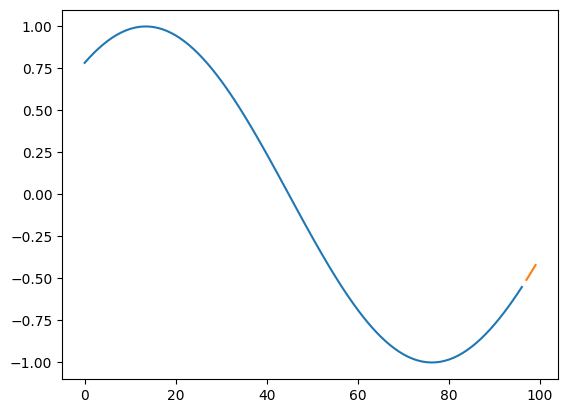

In [3]:
#real training
N = 10 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)


wind_size = 100
y_windowed = []
x_wind = []
y_wind = []

for i in range(wind_size,L):
    curr = y[:,i-wind_size:i]
    res = np.swapaxes(curr,0,1)
    x_wind.append(res[0:97])
    y_wind.append(res[-3:])

x_wind = np.array(x_wind)[:,:,0:1]
y_wind = np.array(y_wind)[:,:,0:1]

x_train = torch.from_numpy(x_wind[0:500])
y_train = torch.from_numpy(y_wind[0:500])
x_test = torch.from_numpy(x_wind[800:])
y_test = torch.from_numpy(y_wind[800:])
print("Shape of train and test datasets")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
x_axis_test = np.arange(0,100)
plt.plot(x_axis_test[0:97],x_wind[5,:,0])
plt.plot(x_axis_test[-3:],y_wind[5,:,0])
plt.show()

In [4]:
x_train.reshape(500,97).shape
y_train.reshape(500,3).shape
# train_loader = torch.utils.data.DataLoader(dataset = x_train.reshape(500,97).to(torch.float), batch_size = 1, shuffle = False)
train_loader = torch.utils.data.DataLoader(list(zip( x_train.reshape(500,97,1).to(torch.float), y_train.reshape(500,3).to(torch.float))), 
                                           batch_size = 1, 
                                           shuffle = False)

In [56]:
class GBRBM(torch.nn.Module):   
	def __init__(self,visible_size,hidden_size,init_var=1e-0,cd_step=1,cd_burning=0,device="cpu"):
		super().__init__()
		self.cd_step = cd_step
		self.cd_burning = cd_burning
		self.visible_size = visible_size
		self.hidden_size = hidden_size
		self.init_var = init_var
		self.device=device
		
		self.linear_layer = nn.Linear(hidden_size,3).to(self.device)
		self.W = nn.Parameter(torch.Tensor(visible_size, hidden_size).to(self.device))
		self.b = nn.Parameter(torch.Tensor(hidden_size).to(self.device))
		self.mu = nn.Parameter(torch.Tensor(visible_size).to(self.device))
		self.log_var = nn.Parameter(torch.Tensor(visible_size).to(self.device))
		self.reset_parameters()

	def reset_parameters(self):
		nn.init.normal_(self.W,
                        std=1.0 * self.init_var /
                        np.sqrt(self.visible_size + self.hidden_size))
		nn.init.constant_(self.b, 0.0)
		nn.init.constant_(self.mu, 0.0)
		nn.init.constant_(self.log_var,
                          np.log(self.init_var))  # init variance = 1.0

	def get_var(self):
		return self.log_var.exp().clip(min=1e-8)

	@torch.no_grad()
	def CD_grad(self,v):
		# v = v.view(v.shape[0], -1)
		prob_h, h, pos_eng = self.positive_energy(v) 

		# negative gradient
		v_neg = torch.randn_like(v)
		neg_eng = self.negative_grad(v_neg)

		return [pos_eng,neg_eng]
		for name, param in self.named_parameters():
			param.grad = pos_eng[name] - neg_eng[name]
	
	@torch.no_grad()
	def negative_grad(self, v):
		var = self.get_var()
		var_mean = var.mean().item()
		samples,_ = self.Gibbs_sampling_vh(v,
										num_steps=self.cd_step,
										burn_in=self.cd_burning)
		v_neg = torch.cat([xx[0] for xx in samples], dim=0)
		h_neg = torch.cat([xx[1] for xx in samples], dim=0)
		grad = self.energy_grad_param(v_neg, h_neg)
		return grad
	
	@torch.no_grad()
	def Gibbs_sampling_vh(self, v, num_steps=10, burn_in=0):
		samples, var = [], self.get_var()
		prob_h_samples = []
		std = var.sqrt()
		h = torch.bernoulli(self.prob_h_given_v(v, var))
		for ii in range(num_steps):
            # backward sampling
			mu = self.prob_v_given_h(h)
			v = mu + torch.randn_like(mu) * std

            # forward sampling
			prob_h = self.prob_h_given_v(v, var)
			h = torch.bernoulli(prob_h)
			if ii >= burn_in:
				samples += [(v, h)]
				prob_h_samples.append(prob_h)
		return samples,prob_h_samples
	
	@torch.no_grad()
	def prob_h_given_v(self, v, var):
		return torch.sigmoid((v / var).mm(self.W) + self.b)

	@torch.no_grad()
	def prob_v_given_h(self, h):
		return h.mm(self.W.T) + self.mu

	@torch.no_grad()
	def positive_energy(self, v):
		prob_h = self.prob_h_given_v(v, self.get_var())
		h = torch.bernoulli(prob_h)
		pos_energy = self.energy_grad_param(v,h)
		return prob_h,h,pos_energy
	
	@torch.no_grad()
	def energy_grad_param(self, v, h):
        # compute the gradient (parameter) of energy averaged over batch size
		var = self.get_var()
		grad = {}
		grad['W'] = -torch.einsum("bi,bj->ij", v / var, h) / v.shape[0]
		grad['b'] = -h.mean(dim=0)
		grad['mu'] = ((self.mu - v) / var).mean(dim=0)
		grad['log_var'] = (-0.5 * (v - self.mu)**2 / var +
		                   ((v / var) * h.mm(self.W.T))).mean(dim=0)
		return grad
	
	@torch.no_grad()
	def reconstruction(self, v):
		v, var = v.view(v.shape[0], -1), self.get_var()
		prob_h = self.prob_h_given_v(v, var)
		v_bar = self.prob_v_given_h(prob_h)
		return F.mse_loss(v, v_bar)
	    
	def compute_linear_layer(self,data):
		# samples,prob_h = self.Gibbs_sampling_vh(data,1,0)
		samples, var = [], self.get_var()
		prob_h_samples = []
		std = var.sqrt()
		h = torch.bernoulli(self.prob_h_given_v(v, var).requires_grad_()).requires_grad_()
            # backward sampling
		mu = self.prob_v_given_h(h)
		v = mu + torch.randn_like(mu) * std

        # forward sampling
		prob_h = self.prob_h_given_v(v, var)
		return self.linear_layer(prob_h[0])
	
	def forward(self,data):
		v = data
		# samples,prob_h = self.Gibbs_sampling_vh(data,1,0)
		samples, var = [], self.get_var()
		prob_h_samples = []
		std = var.sqrt()
		h = torch.bernoulli(self.prob_h_given_v(v, var).requires_grad_()).requires_grad_()
            # backward sampling
		mu = self.prob_v_given_h(h).requires_grad_()
		v = (mu + torch.randn_like(mu) * std).requires_grad_()

        # forward sampling
		prob_h = self.prob_h_given_v(v, var).requires_grad_()
		return self.linear_layer(prob_h[0])
	
	def backward(self, grad_h, grad_c):
		# Backward pass for the LSTM layer
		dweight_ih, dweight_hh = torch.zeros_like(self.weight_ih), torch.zeros_like(self.weight_hh)
		dbias_ih, dbias_hh = torch.zeros_like(self.bias_ih), torch.zeros_like(self.bias_hh)
		
		grad_x = torch.zeros_like(self.weight_ih)

        # Iterate over time steps in reverse order
        for t in reversed(range(seq_len)):
            x_t = x[:, t, :]
            h_t = h[:, t, :]
            c_t = c[:, t, :]
            
            o_t = h_t.tanh() * grad_h + grad_c
            d_o = o_t * (1 - o_t)

            d_c = grad_c + d_o * h_t.tanh()
            d_f = d_c * c_t.sigmoid() * (1 - c_t.sigmoid())
            d_i = d_c * g_t.tanh() * i_t.sigmoid() * (1 - i_t.sigmoid())
            d_g = d_c * i_t.sigmoid() * (1 - g_t.tanh() ** 2)

            grad_x_t = torch.cat([d_i, d_f, d_g, d_o], dim=1)
            grad_h = grad_x_t @ self.weight_ih
            grad_c = grad_c * f_t.sigmoid() + grad_h * g_t.tanh() * i_t.sigmoid() * (1 - i_t.sigmoid())

            # Accumulate gradients for weights and biases
            dweight_ih += grad_x_t.t() @ x_t
            dweight_hh += grad_x_t.t() @ h_t
            dbias_ih += grad_x_t.sum(dim=0)
            dbias_hh += grad_x_t.sum(dim=0)

        # Set gradients for parameters
        self.weight_ih.grad = dweight_ih
        self.weight_hh.grad = dweight_hh
        self.bias_ih.grad = dbias_ih
        self.bias_hh.grad = dbias_hh

		return grad_output


class LSTM_module(nn.Module):
	def __init__(self,input_size=10,hidden_size=500,device="cpu"):
		super(LSTM_module, self).__init__()
		self.input_size = input_size
		self.hidden_size = hidden_size
		self.device = device
		self.lstm1 = nn.LSTM(1, self.hidden_size,batch_first=True).to(device)

	def forward(self,x):
		h_t = torch.zeros(1, x.size(0), self.hidden_size, dtype=torch.float32, requires_grad=True).to(self.device)
		c_t = torch.zeros(1, x.size(0), self.hidden_size, dtype=torch.float32, requires_grad=True).to(self.device)
		out,(h_n,c_n) = self.lstm1(x, (h_t, c_t))
		
		return out[:,-1,:]
	
	def backward(self,grad_output):

		return grad_output

In [52]:
class LSTM_GBRBM(nn.Module):
	def __init__(self,visible_size,hidden_size,optimizer,criterion,scheduler,epoch,clipping,k,learning_rate,cd_step,device="cpu"):
		super(LSTM_GBRBM, self).__init__()
		self.visible_size = visible_size
		self.hidden_size = hidden_size
		self.criterion = criterion
		self.epoch = epoch
		self.clipping = clipping
		self.k = k
		self.learning_rate = learning_rate
		self.cd_step = cd_step
		self.device=device

		# Setting lstm layer and Gaussian Binary Restricted Boltzmann Machine
		self.lstm_layer = LSTM_module(
			input_size=1,
			hidden_size=self.visible_size,
			device=self.device
			)
		
		self.gbrbm = GBRBM(
			visible_size=self.visible_size,
			hidden_size=self.hidden_size,
			cd_step=cd_step,
			device=self.device
			).to(device)
		
		#setting optimizer and learning_rate scheduler
		self.optimizer = self.get_optimizer(optimizer)
		# self.scheduler = self.get_scheduler(scheduler)

		#Setting informazion variables
		self.loss = []
		self.loss_gbrbm = []
		self.lr_list = []

	def get_optimizer(self,optimizer_name):
		if optimizer_name=="adam":
			return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
		return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

	def get_scheduler(self,scheduler_name):
		if scheduler_name == "cosine_anneling":
			return torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.epoch)
		return torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.epoch)
	
	def train(self,train_loader):
		for epoch in range(self.epoch):
			print("Current epoch :{}".format(epoch),end="\r")
			loss, loss_gbrbm = self.train_current_epoch(train_loader)
			self.loss.append(loss)
			self.loss_gbrbm.append(loss_gbrbm)
			self.lr_list.append(self.optimizer.param_groups[0]["lr"])
			# self.scheduler.step()
			print("Current epoch :{} , current error: {}, current error gbrmb: {}".format(epoch,loss,loss_gbrbm),end="\r")
			print("")

	def predict(self,data):
		data_lstm = self.lstm_layer(data)
		pred = self.gbrbm.compute_linear_layer(data_lstm)
		return pred.detach().numpy()

	def forward(self,data):
		data_lstm = self.lstm_layer(data)
		pred = self.gbrbm(data_lstm)
		return pred

	def train_current_epoch(self,train_loader):
		self.lstm_layer.train()
		self.gbrbm.train()

		for ii, (data,target)  in enumerate(train_loader):
			self.optimizer.zero_grad()

			data = data.to(self.device)
			target = target.to(self.device)
			
			pred = self.forward(data)
			linear_loss = self.criterion(pred,target)
			linear_loss.backward()

			data_lstm = self.lstm_layer(data)

			example_loss = self.criterion(data_lstm,data_lstm*1.4)
			example_loss.backward()

			# copy_data = data_lstm.detach().clone()
			[pos_eng,neg_eng] = self.gbrbm.CD_grad(data_lstm)
			# if self.clipping > 0:
			# 	nn.utils.clip_grad_norm_(self.gbrbm.parameters(),self.clipping)
			
			# pred = self.gbrbm.compute_linear_layer(data_lstm)
			
			# make_dot(pred.mean(), params=dict(self.named_parameters()))

			

			# grads_lstm = grad(linear_loss,data_lstm)

			for name, param in self.gbrbm.named_parameters():
				if "layer" not in name:
					param.grad = pos_eng[name] - neg_eng[name]

			self.optimizer.step()
			if ii == len(train_loader) - 1:
				recon_loss = self.gbrbm.reconstruction(data).item()

		return [recon_loss,linear_loss]

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"
clipping = 10.0
learning_rate = 1e-4
training_epochs = 5
cd_step = 1
batch_size = 100
k = 3      
visible_size = 97
hidden_size = 50

'''optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)'''
optimizer ="adam"
criterion_loss = nn.MSELoss()

#multiplicative lr
lmbda = lambda training_epochs: 0.65 ** training_epochs
'''scheduler_multiplicative = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)'''
#cosine anneling
'''scheduler_annelling = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, training_epochs)'''
scheduler_annelling="cosine_anneling"

model_lstm_gbrbm = LSTM_GBRBM(
    visible_size=visible_size,
    hidden_size=hidden_size,
    optimizer = optimizer,
    criterion = criterion_loss,
    scheduler=scheduler_annelling,
    epoch = training_epochs,
    clipping = clipping,
    k = k,
    learning_rate=learning_rate,
    cd_step=cd_step,
    device=device)

model_lstm_gbrbm.train(train_loader=train_loader)

/home/matteo/miniconda3/envs/lstm-snn/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


lstm1.weight_ih_l0 - tensor([0.0173], device='cuda:0', grad_fn=<SelectBackward0>) -None
lstm1.weight_hh_l0 - tensor([ 0.0611,  0.0953,  0.0197, -0.0685,  0.0479,  0.0730, -0.0928, -0.0425,
        -0.0398,  0.0162, -0.0819,  0.0679,  0.0010,  0.0283,  0.0516, -0.0055,
         0.0880,  0.0186, -0.0511,  0.0734, -0.0623, -0.0684, -0.0917,  0.0241,
        -0.0689, -0.0501, -0.0208, -0.0695, -0.0742, -0.0045, -0.0693, -0.0606,
        -0.0682,  0.0593,  0.0976,  0.0635, -0.0837, -0.0378,  0.0494, -0.0737,
         0.0422, -0.0093, -0.0230, -0.0062, -0.0846, -0.0144, -0.0395,  0.0655,
        -0.0289, -0.0497,  0.0125,  0.0812,  0.0836,  0.0596,  0.0900, -0.0340,
        -0.0282, -0.0916, -0.0210, -0.0640, -0.0127, -0.0099,  0.0411, -0.0756,
         0.0481, -0.0039,  0.0528,  0.0567,  0.0827,  0.0894,  0.0975,  0.0134,
         0.0796,  0.0483,  0.0678,  0.0511,  0.0204,  0.0965, -0.0516, -0.0024,
         0.0050,  0.0177, -0.0686, -0.0831,  0.0090, -0.0922, -0.0090, -0.1006,
         0.

In [190]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clipping = 10.0
learning_rate = 1e-4
training_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion_loss = nn.MSELoss()
model = RBM(visible_size, hidden_size).to("cpu")

#multiplicative lr
lmbda = lambda training_epochs: 0.65 ** training_epochs
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
#cosine anneling
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, training_epochs)
lrs = []
loss_list = []
for epoch in range(training_epochs):
    print("Current epoch :{}".format(epoch),end="\r")
    loss = train(model, train_loader,k,optimizer,criterion_loss,clipping,"cpu")
    loss_list.append(loss)
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    print("Current epoch :{} , current error: {}".format(epoch,loss),end="\r")
    print("")


Current epoch :0 , current error: 2.3366894721984863
Current epoch :1 , current error: 0.7966407537460327
Current epoch :2 , current error: 0.709412693977356
Current epoch :3 , current error: 0.16199472546577454
Current epoch :4 , current error: 0.32276207208633423
Current epoch :5 , current error: 0.4405636489391327
Current epoch :6 , current error: 0.6822762489318848
Current epoch :7 , current error: 1.1152538061141968
Current epoch :8 , current error: 0.9938104748725891
Current epoch :9 , current error: 1.0513302087783813
Current epoch :10 , current error: 1.209633469581604
Current epoch :11 , current error: 1.386456847190857
Current epoch :12 , current error: 1.366353154182434
Current epoch :13 , current error: 1.404934287071228
Current epoch :14 , current error: 1.5248082876205444
Current epoch :15 , current error: 1.4583466053009033
Current epoch :16 , current error: 1.291817545890808
Current epoch :17 , current error: 1.3796501159667969
Current epoch :18 , current error: 1.47081

In [56]:
model_lstm_gbrbm.gbrbm.eval()
for idx, (data,target) in enumerate(train_loader):

    print(model_lstm_gbrbm.predict(data))


    break

[-0.3197913  -0.3204889  -0.31809163]


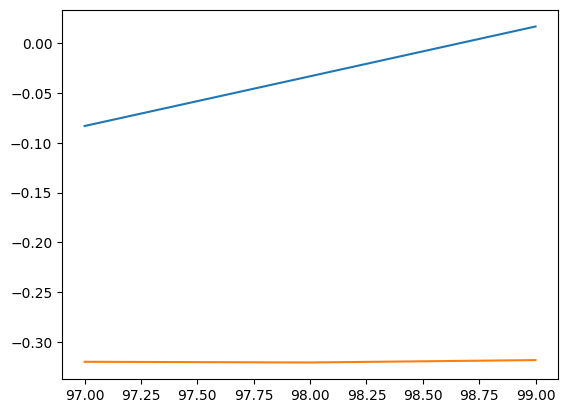

In [57]:
model_lstm_gbrbm.gbrbm.eval()
for idx, (data,target) in enumerate(train_loader):
    # plt.plot(np.arange(data[0].size()[0]),data[0].detach().numpy())
    # el = model_lstm_gbrbm.gbrbm.Gibbs_sampling_vh(data,10,0)
    # plt.plot(np.arange(data[0].size()[0]),el[9][0][0].detach().numpy())
    # plt.plot()

    pred = model_lstm_gbrbm.predict(data)
    plt.plot(np.arange(97,100),target[0].detach().numpy())
    plt.plot(np.arange(97,100),pred)
    plt.show    
    # print(model.reconstruction(data))
    break



In [78]:
el[0][0][0].size()

torch.Size([97])

tensor([[ 0.8150,  0.0994, -0.7543,  0.2780,  0.1791, -1.7397, -1.9446,  0.3875,
          1.6345, -0.0810,  3.2175, -0.4969,  1.3375, -0.3316, -0.2367, -0.2780,
          0.2084,  0.6755, -0.7847,  1.0824,  0.6697, -0.7179, -0.5987, -0.5132,
          1.6594, -1.1474,  2.3361, -0.7586,  1.0284, -2.2064,  0.0538, -0.2185,
          0.0422,  1.8315,  0.4363, -0.2244,  0.6477,  1.6035,  1.2889, -1.5369,
         -0.7978,  1.2588,  0.8043,  0.3315, -1.1734, -0.3758,  0.0315,  0.3934,
          0.8685, -0.7271,  1.0756,  1.4819, -0.8851, -1.0825, -0.0942, -0.2020,
          0.2406, -0.7031,  0.6123,  0.6961, -0.6054,  0.1026,  2.0290, -0.5103,
         -0.9944,  0.9638, -1.4257, -0.4388, -0.1691,  0.6004,  1.1382,  0.2174,
          0.5585, -0.1850, -0.4877, -1.0977, -1.4632, -0.7434,  0.7652,  0.0602,
         -1.7003,  0.4793,  0.2532, -0.2037, -1.2466,  1.0678,  0.0328,  1.8162,
          0.1775, -1.6017,  0.2911,  1.5154,  1.6075,  0.9719,  0.2402,  0.6923,
          1.5587]], device='

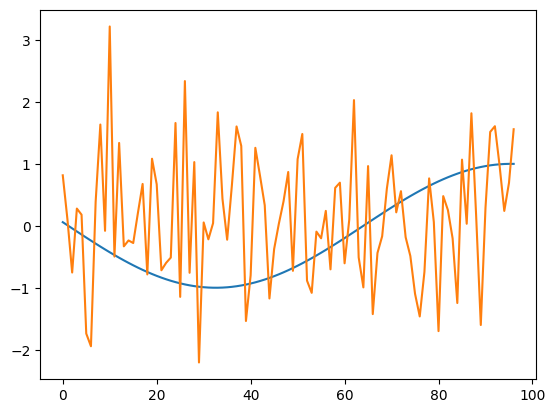

In [74]:
for batch in train_loader:  
    el = batch.numpy()[0]
    plt.plot(np.arange(el.shape[0]),el)

    v = model.predict(batch).to(device)
    s = v.cpu().detach().numpy()[0]
    plt.plot(np.arange(s.shape[0]),s)
    print(v)
    break